# DoomTakeCover-v0

In [1]:
import numpy as np
import os
import json
import tensorflow as tf
import random
from vae.vae import CVAE
# from controller import make_controller
# from env import make_env|
from utils import PARSER
args = PARSER.parse_args(['--config_path', 'configs/boxing.config'])

In [2]:
import matplotlib.pyplot as plt
import matplotlib.animation
%matplotlib inline
np.set_printoptions(precision=4, edgeitems=6, linewidth=100, suppress=True)

In [3]:
print(args.exp_name)

WorldModels


In [4]:
print(args.env_name)

Boxing-v0


In [5]:
os.environ["CUDA_VISIBLE_DEVICES"]="-1" # disable GPU

DATA_DIR = "results/{}/{}/record".format(args.exp_name, args.env_name)
model_path_name = "results/{}/{}/tf_vae".format(args.exp_name, args.env_name)

In [6]:
filelist = os.listdir(DATA_DIR)

In [7]:
obs = np.load(os.path.join(DATA_DIR, random.choice(filelist)))["obs"]
obs = obs.astype(np.float32)/255.0

In [8]:
obs.shape

(2381, 64, 64, 3)

In [9]:
# need reshape to convert 64x64x3 into 1x64x64x3
frame = random.choice(obs).reshape(1, 64, 64, 3)

In [10]:
vae = CVAE(args)

vae.set_weights(tf.keras.models.load_model(model_path_name, compile=False).get_weights())

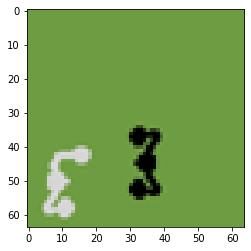

In [11]:
%matplotlib inline
# show recorded frame that will be fed into the input of VAE
plt.imshow(frame[0])
plt.show()

In [12]:
batch_z = vae.encode(frame)
print(batch_z[0]) # print out sampled z
reconstruct = vae.decode(batch_z)

tf.Tensor(
[ 1.3395 -0.2131 -0.3148 -0.04   -0.5175  0.5909 -0.8853  0.3253  1.3298  0.9091 -0.5933  1.0592
 -0.2778 -0.1958 -0.0605  2.0318  0.9893 -0.3659 -0.7904 -0.6137 -0.3036  0.0445  0.5994  0.9576
  0.6055  0.85    0.1187 -0.3205  0.2889 -0.3444 -1.839   0.0884], shape=(32,), dtype=float32)


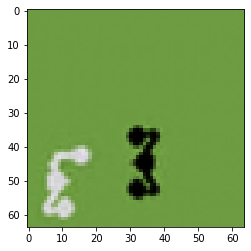

In [13]:
%matplotlib inline
# show reconstruction
plt.imshow(reconstruct[0])
plt.show()

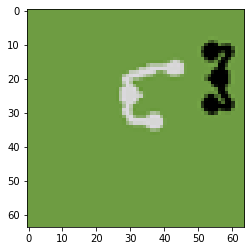

tf.Tensor(
[ 0.7003  0.4719 -0.1843  1.2291  0.3679 -0.7153  1.6427 -0.2343  1.0213  1.1052 -1.7827  2.1235
  0.3507 -1.791   0.6432  0.6356 -0.3991  1.0805 -0.4763  1.3033  1.851  -1.426  -0.7507 -1.7261
  0.6298  0.929   0.0919 -1.763   0.4658  0.4534  0.291   0.8157], shape=(32,), dtype=float32)


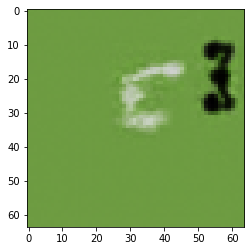

In [14]:
# need reshape to convert 64x64x3 into 1x64x64x3
frame = random.choice(obs).reshape(1, 64, 64, 3)

%matplotlib inline
# show recorded frame that will be fed into the input of VAE
plt.imshow(frame[0])
plt.show()

batch_z = vae.encode(frame)
print(batch_z[0]) # print out sampled z
reconstruct = vae.decode(batch_z)

%matplotlib inline
# show reconstruction
plt.imshow(reconstruct[0])
plt.show()

# Sample the VAE

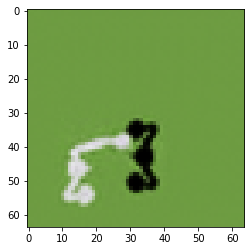

In [15]:
# np.random.seed(68)
sample = np.random.rand(32).reshape(-1, 32)
reconstruct = vae.decode(sample)
%matplotlib inline
# show reconstruction
plt.imshow(reconstruct[0])
plt.show()

## Dream Samples

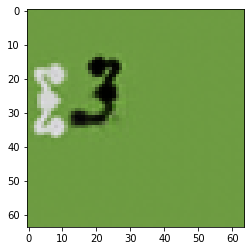

In [16]:
%matplotlib inline
batch_z = tf.random.normal((1, args.z_size)).numpy()
reconstruct = vae.decode(batch_z)
# show reconstruction
plt.imshow(reconstruct[0])
plt.show()

# Simulate and Store for Animation

In [17]:
def sim(c, env, vae, is_true_env=False, z_size=64, max_ep_len=1000):
    o = env.reset()
    r_list = []
    total_r_list = []
    true_frames = []
    if is_true_env:
        o, frame = o
        true_frames.append(tf.squeeze(frame))
        z = np.expand_dims(o[:z_size], axis=0)
        reconstruct = vae.decode(z)
    else:
        z = np.expand_dims(o[:z_size], axis=0)
        reconstruct = vae.decode(z)
    decoded_frames = [tf.squeeze(reconstruct)]
    
    for _ in range(max_ep_len): # episode length is a thousand
        a = c.get_action(o)
        o, r, d, _ = env.step(a)
        r_list.append(r)
        total_r_list.append(sum(r_list))
        if is_true_env:
            env.render('rgb_array')
            o, frame = o
            true_frames.append(tf.squeeze(frame))
            z = np.expand_dims(o[:z_size], axis=0)
            reconstruct = vae.decode(z)
        else:
            z = np.expand_dims(o[:z_size], axis=0)
            reconstruct = vae.decode(z)
        decoded_frames.append(tf.squeeze(reconstruct))
        
        if d:
            break
    return decoded_frames, true_frames, r_list, total_r_list

## Acting in dream environment
visualize what the agent sees when acting in the dream environment

In [18]:
c = make_controller(args)
c.load_model('results/{}/{}/log/{}.cma.16.64.json'.format(args.exp_name, args.env_name, args.env_name))
true_env = make_env(args, dream_env=True, with_obs=True)
reconstruct_episode, _, dream_r, dream_total_r = sim(c, true_env, vae, is_true_env=False, z_size=args.z_size, max_ep_len=args.max_frames)
true_env.close()

NameError: name 'make_controller' is not defined

In [ ]:
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
# stupid jupyter bug, just keep copy pasting until it works

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation

f = plt.figure()
ax = f.gca()

image = plt.imshow(reconstruct_episode[0].numpy(), interpolation='None', animated=True)

def function_for_animation(frame_index):
    image.set_data(reconstruct_episode[frame_index+1].numpy())
    ax.set_title('frame: {}, r: {:.2f}, total reward: {:.2f}'.format(frame_index, dream_r[frame_index+1], dream_total_r[frame_index+1]))
    return image,

ani = matplotlib.animation.FuncAnimation(f, function_for_animation, interval=40, frames=len(reconstruct_episode), blit=True)


## Acting in true environment
visualize what the agent sees when acting in the true environment

In [ ]:
c = make_controller(args)
c.load_model('results/{}/{}/log/{}.cma.16.64.json'.format(args.exp_name, args.env_name, args.env_name))
true_env = make_env(args, dream_env=False, with_obs=True)
reconstruct_episode, true_episode, true_r, true_total_r = sim(c, true_env, vae, is_true_env=True, z_size=args.z_size, max_ep_len=args.max_frames)
true_env.close()

In [ ]:
%matplotlib notebook
# stupid jupyter bug, just keep copy pasting until it works

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation

f = plt.figure()
ax = f.gca()

image = plt.imshow(true_episode[0].numpy(), interpolation='None', animated=True)

def function_for_animation(frame_index):
    image.set_data(true_episode[frame_index+1].numpy())
    ax.set_title('frame: {}, r: {:.2f}, total reward: {:.2f}'.format(frame_index, true_r[frame_index+1], true_total_r[frame_index+1]))
    return image,

ani = matplotlib.animation.FuncAnimation(f, function_for_animation, interval=40, frames=len(true_episode), blit=True)


## Return Table for Controller

In [ ]:
eager_filepath = os.path.join('results/{}/{}/log/{}.cma.16.64.eval_hist.json'.format(args.exp_name, args.env_name, args.env_name))

with open(eager_filepath, 'r') as f:
  eager_data = json.load(f)
eager_data = np.array(eager_data)

eager_generation = int(eager_data[20, 0])
eager_ret = eager_data[20, 1]
eager_std = eager_data[20, 2]

og_generation = 2000
og_tau_1_ret = 868.0
og_tau_1_std = 511.0

print(eager_generation, eager_ret, eager_std)
print(og_generation, og_tau_1_ret, og_tau_1_std)

|  | generation | returns &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|
|------|------|---------|
|   OG WorldModels  | 2000 | $868 \pm 511$ |
|   Eager WorldModels  | 200 | $867 \pm 557$ |

# CarRacing-v0

In [ ]:
import numpy as np
import os
import json
import tensorflow as tf
import random
from vae.vae import CVAE
from controller import make_controller
from env import make_env
from utils import PARSER
args = PARSER.parse_args(['--config_path', 'configs/carracing.config'])

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation
%matplotlib inline
np.set_printoptions(precision=4, edgeitems=6, linewidth=100, suppress=True)

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"]="-1" # disable GPU

DATA_DIR = "results/{}/{}/record".format(args.exp_name, args.env_name)
model_path_name = "results/{}/{}/tf_vae".format(args.exp_name, args.env_name)

In [ ]:
filelist = os.listdir(DATA_DIR)

In [ ]:
obs = np.load(os.path.join(DATA_DIR, random.choice(filelist)))["obs"]
obs = obs.astype(np.float32)/255.0

In [ ]:
obs.shape

In [ ]:
frame = random.choice(obs).reshape(1, 64, 64, 3)

In [ ]:
vae = CVAE(args)

vae.set_weights(tf.keras.models.load_model(model_path_name, compile=False).get_weights())

In [ ]:
%matplotlib inline
# show recorded frame that will be fed into the input of VAE
plt.imshow(frame[0])
plt.show()

In [ ]:
batch_z = vae.encode(frame)
print(batch_z[0]) # print out sampled z
reconstruct = vae.decode(batch_z)

In [ ]:
%matplotlib inline
# show reconstruction
plt.imshow(reconstruct[0])
plt.show()

## Dream Samples

In [ ]:
%matplotlib inline
batch_z = tf.random.normal((1, args.z_size)).numpy()
reconstruct = vae.decode(batch_z)
# show reconstruction
plt.imshow(reconstruct[0])
plt.show()

## Driving in true environment
visualize what the agent sees when driving in the true environment

In [ ]:
c = make_controller(args)
c.load_model('results/{}/{}/log/{}.cma.16.64.json'.format(args.exp_name, args.env_name, args.env_name))
true_env = make_env(args, dream_env=False, with_obs=True)
reconstruct_episode, true_episode, true_r, true_total_r = sim(c, true_env, vae, is_true_env=True, z_size=args.z_size, max_ep_len=args.max_frames)
true_env.close()

In [ ]:
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
# stupid jupyter bug, just keep copy pasting until it works

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation

f = plt.figure()
ax = f.gca()

image = plt.imshow(true_episode[0].numpy(), interpolation='None', animated=True)

def function_for_animation(frame_index):
    image.set_data(reconstruct_episode[frame_index+1].numpy())
    ax.set_title('frame: {}, r: {:.2f}, total reward: {:.2f}'.format(frame_index, true_r[frame_index+1], true_total_r[frame_index+1]))
    return image,

ani = matplotlib.animation.FuncAnimation(f, function_for_animation, interval=40, frames=len(true_episode), blit=True)


## Return Plot for Controller

In [ ]:
eager_filepath = os.path.join('results/{}/{}/log/{}.cma.16.2.eval_hist.json'.format(args.exp_name, args.env_name, args.env_name))

with open(eager_filepath, 'r') as f:
  eager_data = json.load(f)
eager_data = np.array(eager_data)
eager_comparison_max = eager_data[-1, 0] # b/c we didnt run for 2k

In [ ]:
%matplotlib inline

eager_x = eager_data[:, 0]
eager_ret = eager_data[:, 1]
eager_std = eager_data[:, 2]


plt.figure()
plt.plot(eager_x, eager_ret)
plt.fill_between(eager_x, eager_ret-eager_std, eager_ret+eager_std, alpha=0.2)

plt.title('CarRacing-v0')
plt.ylabel('avg. episode reward')
plt.xlabel('generation')
plt.legend(['eager', 'D. Ha original'])